## Annotated Multi-Head Attention and Positional Encoding

This file contains useful visualizations to understand what we're working with and to understand changes brought to existing code, such as to the positional encoding.

This is therefore adapted from this project and under this license:
> http://nlp.seas.harvard.edu/2018/04/03/attention.html
> 
> MIT License, Copyright (c) 2018 Alexander Rush. 

It is now sublicensed as a new project:
> https://github.com/guillaume-chevalier/Linear-Attention-Recurrent-Neural-Network
> 
> MIT License, Copyright (c) 2018 Guillaume Chevalier

Here, some things such as Attention Masks were removed. Also, the flag `linears=True` is added, and useful debugging prints are made to test the dimensions.

The positional encoding is also quite changed (see at the end below).

In [86]:
import copy
import math

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np


def clones(module, N):
    # This function is adapted from:
    #     https://github.com/harvardnlp/annotated-transformer
    #     MIT License, Copyright (c) 2018 Alexander Rush
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


def attention(query, key, value, dropout=None):
    # This function is adapted from:
    #     https://github.com/harvardnlp/annotated-transformer
    #     MIT License, Copyright (c) 2018 Alexander Rush
    
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    print("    key 1:", key.size())
    key = key.transpose(-2, -1)
    print("    key 2:", key.size())
    print("    query:", query.size())
    scores = torch.matmul(query, key) / math.sqrt(d_k)
    print("    scores:", scores.size())
    p_attn = F.softmax(scores, dim = -1)
    print("    p_attn:", p_attn.size())
    if dropout is not None:
        p_attn = dropout(p_attn)
    attention_result = torch.matmul(p_attn, value)
    print("    attention_result:", attention_result.size())
    return attention_result, p_attn


class MultiHeadedAttention(nn.Module):
    # This class is adapted from:
    #     https://github.com/harvardnlp/annotated-transformer
    #     MIT License, Copyright (c) 2018 Alexander Rush
    
    def __init__(self, h, hidden_size, linears=True, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert hidden_size % h == 0
        # We assume d_v always equals d_k
        self.d_k = hidden_size // h
        self.h = h
        if linears: 
            self.linears = clones(nn.Linear(hidden_size, hidden_size), 4)
        else:
            self.linears = [lambda arg: arg] * 4
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value):
        "Implements Figure 2"
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from hidden_size => h x d_k 
        print("query, key, value 1:", query.size(), key.size(), value.size())
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        print("query, key, value 2:", query.size(), key.size(), value.size())
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, self.dropout)
        print("x 1:", x.size())
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        print("x 2:", x.size())
        
        x = self.linears[-1](x)
        print("x 3:", x.size())
        return x

    
batch_size = 64
sequence_length = 10
hidden_size = 32
attention_heads = 8


mha = MultiHeadedAttention(h=attention_heads, hidden_size=hidden_size)


print("With as many attention queries as there are values:\n")
query = torch.tensor(np.ones([batch_size, 1, hidden_size])).float()
value = torch.tensor(np.ones([batch_size, sequence_length, hidden_size])).float()
result = mha.forward(query, value, value)
print("result:", result.size())
print("\n")

print("With a single attention query:\n")
query = torch.tensor(np.ones([batch_size, sequence_length, hidden_size])).float()
value = torch.tensor(np.ones([batch_size, sequence_length, hidden_size])).float()
result = mha.forward(query, value, value)
print("result:", result.size())

With as many attention queries as there are values:

query, key, value 1: torch.Size([64, 1, 32]) torch.Size([64, 10, 32]) torch.Size([64, 10, 32])
query, key, value 2: torch.Size([64, 8, 1, 4]) torch.Size([64, 8, 10, 4]) torch.Size([64, 8, 10, 4])
    key 1: torch.Size([64, 8, 10, 4])
    key 2: torch.Size([64, 8, 4, 10])
    query: torch.Size([64, 8, 1, 4])
    scores: torch.Size([64, 8, 1, 10])
    p_attn: torch.Size([64, 8, 1, 10])
    attention_result: torch.Size([64, 8, 1, 4])
x 1: torch.Size([64, 8, 1, 4])
x 2: torch.Size([64, 1, 32])
x 3: torch.Size([64, 1, 32])
result: torch.Size([64, 1, 32])


With a single attention query:

query, key, value 1: torch.Size([64, 10, 32]) torch.Size([64, 10, 32]) torch.Size([64, 10, 32])
query, key, value 2: torch.Size([64, 8, 10, 4]) torch.Size([64, 8, 10, 4]) torch.Size([64, 8, 10, 4])
    key 1: torch.Size([64, 8, 10, 4])
    key 2: torch.Size([64, 8, 4, 10])
    query: torch.Size([64, 8, 10, 4])
    scores: torch.Size([64, 8, 10, 10])
    p

torch.Size([1, 128, 42])
torch.Size([1, 128, 42])


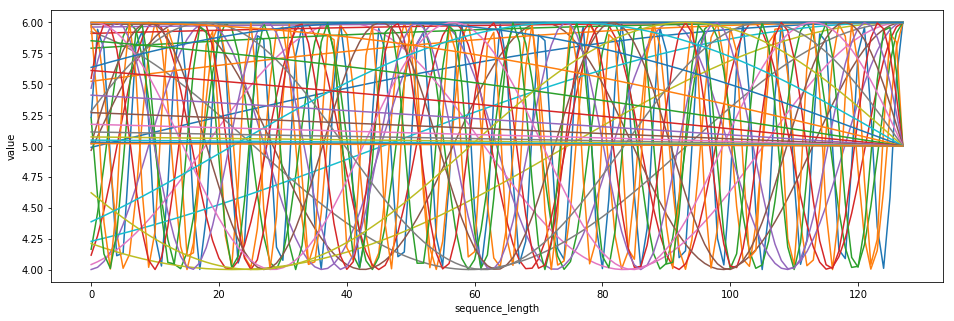

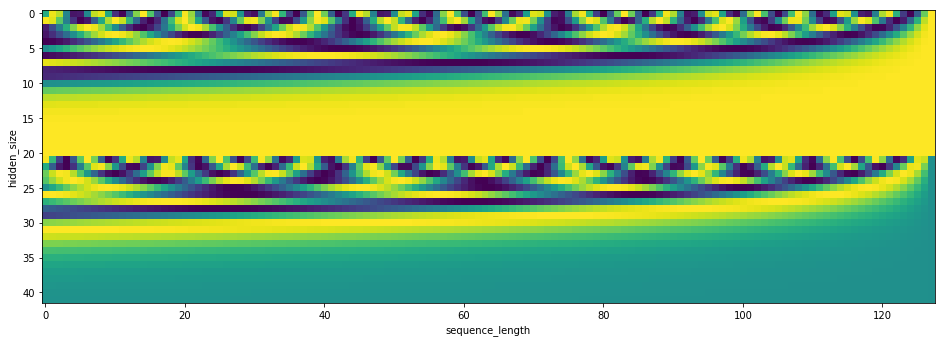

In [150]:
from torch.autograd import Variable
import matplotlib.pyplot as plt

%matplotlib inline


class PositionalEncoding(nn.Module):
    # This class is adapted from:
    #     https://github.com/harvardnlp/annotated-transformer
    #     MIT License, Copyright (c) 2018 Alexander Rush
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, int(d_model/2):] = torch.sin(position * div_term)
        pe[:, :int(d_model/2)] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        pos = Variable(self.pe[:, :x.size(1)], requires_grad=False)
        x = x + pos
        return self.dropout(x), pos


batch_size = 1
hidden_size = 42
sequence_length = 128
input_tensor = Variable(torch.ones(batch_size, sequence_length, hidden_size)) * 5  # Note the multiply by 5.

pe = PositionalEncoding(d_model=hidden_size, dropout=0, max_len=sequence_length)
y, pos = pe.forward(input_tensor)
print(input_tensor.size())
print(y.size())

plt.figure(figsize=(16, 5))
plt.plot(np.arange(sequence_length), y[0, :, :].data.numpy()[::-1])
plt.ylabel("value")
plt.xlabel("sequence_length")

plt.figure(figsize=(16, 8))
plt.imshow(y[0, ::, :].data.numpy()[::-1].transpose(), interpolation='none')
plt.ylabel("hidden_size")
plt.xlabel("sequence_length")
plt.show()


## Edits to the PositionalEncoding class

Let's concatenate the positional embedding to x rather than to add it (such as doing like a DenseNet rather than a ResNet for the position encoding). 

Also, let's encode things with more numerically-pleasing sine waves.

Let's start by deriving the code from the following tweet about positional encoding: 
> https://twitter.com/guillaume_che/status/974801468887838720

68 9 128
(17, 128)


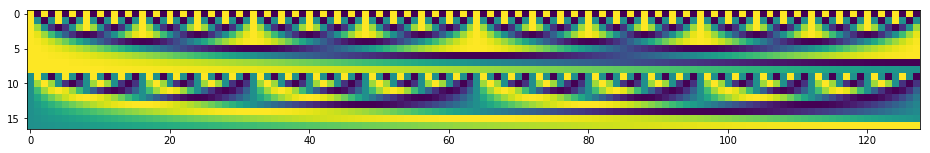

In [88]:
import numpy as np
import matplotlib.pyplot as plt

import math

sequence_length = 68
b = math.ceil(math.log(sequence_length*4, 2))
a = int(2**b / 4)  # Up to a quarter of a sine wave
print(sequence_length, b, a)
x1 = np.array([[math.cos(0.5**i*x*2*math.pi) for x in range(0, a)] for i in range(1, b+1)])
x2 = np.array([[math.sin(0.5**i*x*2*math.pi) for x in range(0, a)] for i in range(2, b+1)])
x = np.concatenate([x1, x2], axis=0)
print(x.shape)

# Looks like a progression of binary numbers, but with float values. 
plt.figure(figsize=(16, 3))
plt.imshow(x, interpolation='none')
plt.show()

5
x.shape(): (18, 128)
x.shape(): (1, 18, 128)
pe.size(): torch.Size([1, 128, 18])
pe.size(), x.size(): torch.Size([1, 128, 18]) torch.Size([1, 128, 42])
torch.Size([1, 128, 42])
torch.Size([1, 128, 60])


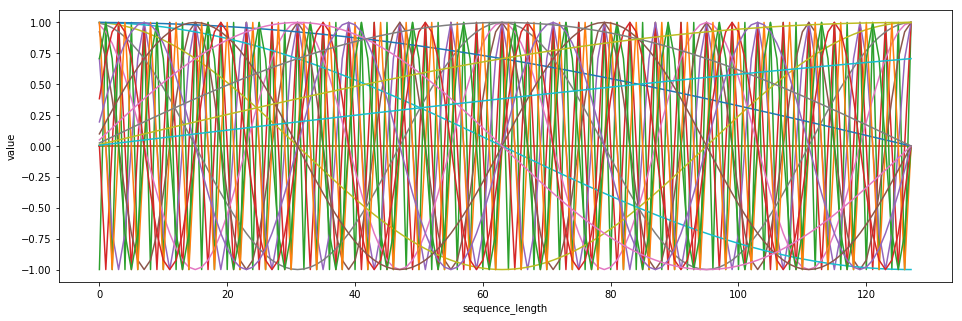

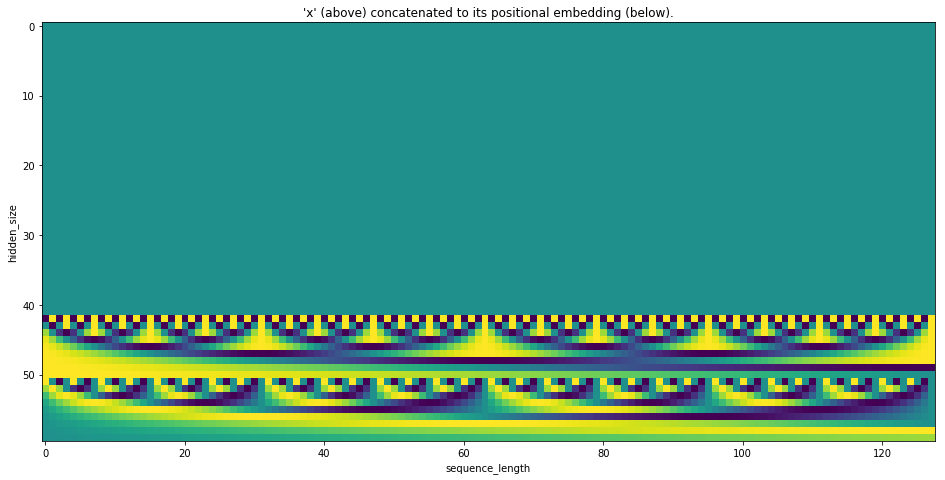

In [157]:
import math
print(math.ceil(4.2))

class PositionalEncoding(nn.Module):
    # This class is adapted from:
    #     https://github.com/harvardnlp/annotated-transformer
    #     MIT License, Copyright (c) 2018 Alexander Rush
    # Is sublicensed:
    #     https://github.com/guillaume-chevalier/Linear-Attention-Recurrent-Neural-Network
    #     MIT License, Copyright (c) 2018 Guillaume Chevalier
    "Implement the edited PE function, depends on sequence length rather than input dimensionnality."

    def __init__(self, batch_size, max_sequence_length, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log_2 space ceiled to sequence_length.
        b = math.ceil(math.log(max_sequence_length * 4, 2))
        a = int(2**b / 4)  # Up to a quarter of a sine wave
        x1 = np.array([[math.cos(0.5**i*x*2*math.pi) for x in range(max_sequence_length, 0, -1)] for i in range(1, b+1)])
        x2 = np.array([[math.sin(0.5**i*x*2*math.pi) for x in range(max_sequence_length, 0, -1)] for i in range(2, b+2)])
        x = np.concatenate([x1, x2], axis=0)
        print("x.shape():", x.shape)
        x = np.expand_dims(x, 0).repeat(repeats=batch_size, axis=0)
        print("x.shape():", x.shape)

        # Register it into PyTorch
        pe = torch.from_numpy(x).float()
        pe = pe.transpose(-1, -2)
        print("pe.size():", pe.size())
        self.register_buffer('pe', pe)

    def forward(self, x):
        pos = Variable(self.pe, requires_grad=False)
        # print(pos.size(), x.size())  # [batch_size, -1, sequence_length], [batch_size, sequence_length, hidden_size]
        pe = self.pe[:, -x.size(1):]  # limiting positional encoding to a poentially shorter sequence_length
        print("pe.size(), x.size():", pe.size(), x.size())
        x = torch.cat([x, pe], dim=-1)
        return self.dropout(x), pos


batch_size = 1
hidden_size = 42
sequence_length = 128
input_tensor = Variable(torch.zeros(batch_size, sequence_length, hidden_size))

pe = PositionalEncoding(batch_size, sequence_length, dropout=0)
y, pos = pe.forward(input_tensor)
print(input_tensor.size())
print(y.size())

plt.figure(figsize=(16, 5))
plt.plot(np.arange(sequence_length), y[0, :, :].data.numpy()[::-1])
plt.ylabel("value")
plt.xlabel("sequence_length")
plt.show()

plt.figure(figsize=(16, 8))
plt.title("'x' (above) concatenated to its positional embedding (below).")
plt.imshow(y[0, :, :].data.numpy()[::-1].transpose(), interpolation='none')
plt.ylabel("hidden_size")
plt.xlabel("sequence_length")
plt.show()


It now somehow looks like a perfect progression of numbers in binary, but with float intermediary values rather than all zeros and ones. E.g.:

1. 0001
2. 0010
3. 0011
4. 0100
5. 0101
6. 0110
7. 0111
8. 1000

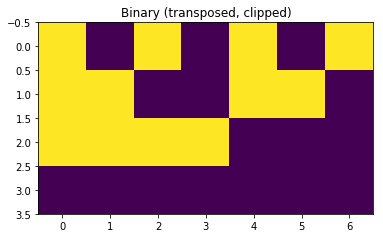

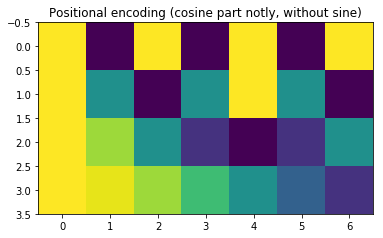

In [158]:
binary = """0001
0010
0011
0100
0101
0110
0111
1000"""
transposed_binary = np.array([[int(x) for x in a] for a in binary.split("\n")]).transpose()[::-1, ::-1][:, 1:]
plt.imshow(transposed_binary)
plt.title("Binary (transposed, clipped)")
plt.show()

plt.imshow(pos[0].data.transpose(0, 1)[:4, :7])
plt.title("Positional encoding (cosine part notly, without sine)")
plt.show()